In [1]:
import scanpy as sc

In [2]:
adata = sc.read_10x_h5("/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5")

print(adata)

AnnData object with n_obs × n_vars = 68255 × 0
    var: 'gene_ids', 'feature_types', 'genome'


In [3]:
import h5py

with h5py.File("/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5", "r") as f:
    print(list(f.keys()))

['matrix']


sc.read_10x_h5()로 불러왔을 때 , 68255 (유전자 열이 없음)
h5py로 열어보니깐 key가 matrix 하나만 존재


이 파일은 10x Genomics 공식 형식 (h5, key=’matrix’, ‘features’, ‘barcodes’ 등) 아닌, TISCH2에서 제공하는 커스텀 hdf5 파일이다.

### anndata 객체로 변환

현재 키가 matrix 하나라서, 그 내부를 열어야 한다.

data → 실제 count 값 (sparse matrix 형태)

indices, indptr, shape → CSR 포맷 정보

barcodes → 세포 ID

features 또는 genes → 유전자 ID

In [4]:

with h5py.File("/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5", "r") as f:
    print(list(f["matrix"].keys()))

['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']


In [5]:
import scipy.sparse as sp
import numpy as np
import anndata as ad

In [6]:
file = "/Users/yanghyejeong/Documents/study/Data/NSCLC_GSE162498_expression.h5"


with h5py.File(file, "r") as f:
    grp = f["matrix"]
    
    data = grp["data"][:]
    indices = grp["indices"][:]
    indptr = grp["indptr"][:]
    shape = grp["shape"][:]

    # CSC 포맷으로 읽기 (gene × cell)
    X = sp.csc_matrix((data, indices, indptr), shape=shape)

    # 바코드 / 유전자 이름 확인
    barcodes = [x.decode("utf-8") for x in grp["barcodes"][:]]
    
    if "name" in grp["features"]:
        genes = [x.decode("utf-8") for x in grp["features"]["name"][:]]
    elif "gene_names" in grp["features"]:
        genes = [x.decode("utf-8") for x in grp["features"]["gene_names"][:]]
    else:
        genes = [x.decode("utf-8") for x in grp["features"]["id"][:]]
    
    gene_ids = [x.decode("utf-8") for x in grp["features"]["id"][:]]

# AnnData 객체 생성 (행=세포, 열=유전자로 transpose 필요)
adata = ad.AnnData(X.transpose())
adata.obs_names = barcodes
adata.var_names = genes
adata.var["gene_ids"] = gene_ids

In [7]:
print(adata)

AnnData object with n_obs × n_vars = 68255 × 24410
    var: 'gene_ids'


### Scanapy 에서 QC 유전자 그룹 식별

In [8]:
# mitochondrail genes, "MT-"
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [9]:
# QC metric 계산
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo","hb"],
    inplace=True,
    log1p=False,
    percent_top=None
)

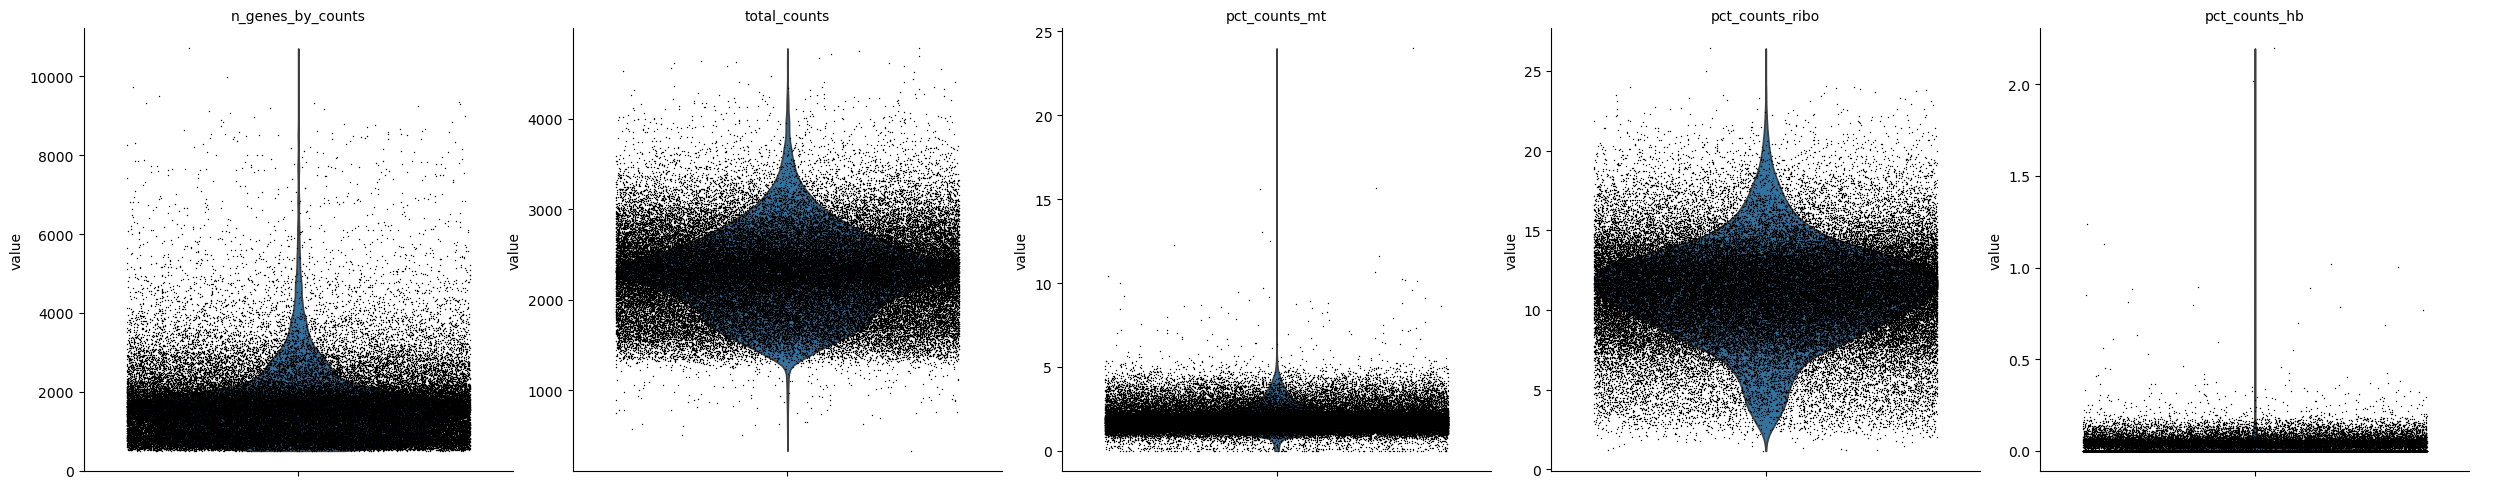

In [10]:
# QC violin plot
sc.pl.violin(
    adata,
    ["n_genes_by_counts","total_counts","pct_counts_mt","pct_counts_ribo","pct_counts_hb"],
    jitter=0.4,
    multi_panel=True
)

저품질 세포 제거

In [11]:
# 필터링
adata_qc = adata[
    (adata.obs["n_genes_by_counts"] > 200) &
    (adata.obs["n_genes_by_counts"] < 5000) &
    (adata.obs["pct_counts_mt"] < 20),
    :
].copy()


print(f"QC 전 세포 수 : {adata.n_obs}")
print(f"QC 후 세포 수 : {adata_qc.n_obs}")

QC 전 세포 수 : 68255
QC 후 세포 수 : 67603


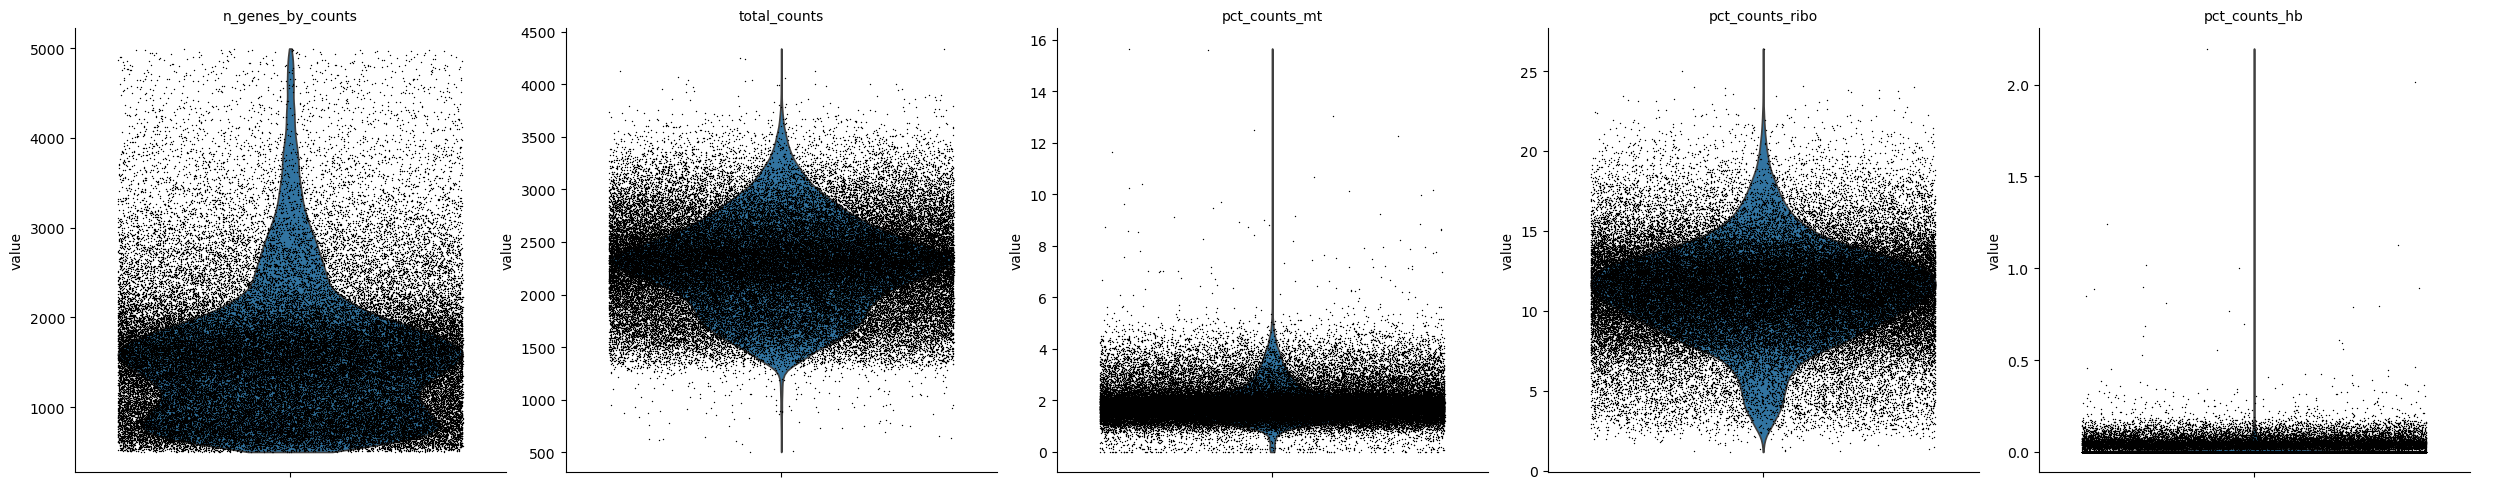

In [12]:
sc.pl.violin(
    adata_qc,
    ["n_genes_by_counts","total_counts","pct_counts_mt","pct_counts_ribo","pct_counts_hb"],
    jitter=0.4,
    multi_panel=True
)

미토콘트드리아 유전자 발현 비율 상위 5개

In [13]:
print(adata.obs["pct_counts_mt"].head())

GSM4952953@AAACGGGCAGCTCGAC-1    1.382725
GSM4952953@AAAGCAAAGCGAAGGG-1    1.428726
GSM4952953@AAATGCCCAGAGTGTG-1    2.127167
GSM4952953@AACCATGTCTTGTACT-1    1.559541
GSM4952953@AACTCCCTCGAATGGG-1    1.659165
Name: pct_counts_mt, dtype: float32


총 발현량과 유전자 수를 산점도로 시각화

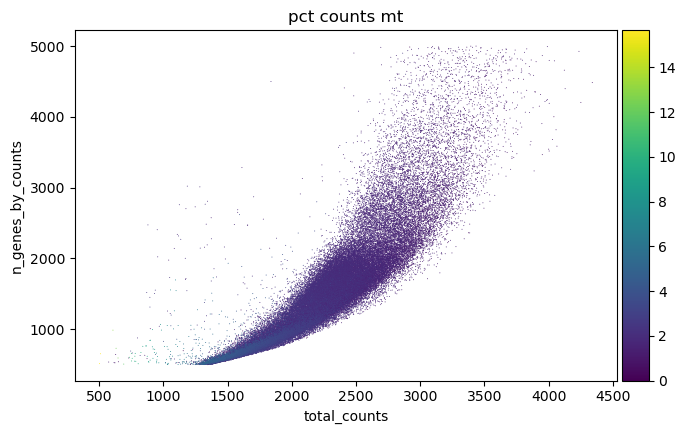

In [14]:
sc.pl.scatter(adata_qc, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Doublet detection

scrublet 사용하여 이중 세포 감지

In [15]:
print(adata_qc.obs.head())

                               n_genes_by_counts  total_counts  \
GSM4952953@AAACGGGCAGCTCGAC-1               1184   1840.053711   
GSM4952953@AAAGCAAAGCGAAGGG-1               1231   1811.295410   
GSM4952953@AAATGCCCAGAGTGTG-1                692   1632.593140   
GSM4952953@AACCATGTCTTGTACT-1               1334   2230.066406   
GSM4952953@AACTCCCTCGAATGGG-1               1126   1897.334229   

                               total_counts_mt  pct_counts_mt  \
GSM4952953@AAACGGGCAGCTCGAC-1        25.442890       1.382725   
GSM4952953@AAAGCAAAGCGAAGGG-1        25.878445       1.428726   
GSM4952953@AAATGCCCAGAGTGTG-1        34.727982       2.127167   
GSM4952953@AACCATGTCTTGTACT-1        34.778809       1.559541   
GSM4952953@AACTCCCTCGAATGGG-1        31.479902       1.659165   

                               total_counts_ribo  pct_counts_ribo  \
GSM4952953@AAACGGGCAGCTCGAC-1         315.272400        17.133869   
GSM4952953@AAAGCAAAGCGAAGGG-1         314.411133        17.358358   
GSM49

In [16]:
# sample columns 생성
adata_qc.obs["sample"] = adata_qc.obs_names.str.split('@').str[0]

# scrublet 실행
sc.pp.scrublet(adata_qc, batch_key='sample')

In [17]:
print(adata_qc.obs[['doublet_score', 'predicted_doublet']].head())

                               doublet_score  predicted_doublet
GSM4952953@AAACGGGCAGCTCGAC-1       0.042383              False
GSM4952953@AAAGCAAAGCGAAGGG-1       0.036959              False
GSM4952953@AAATGCCCAGAGTGTG-1       0.045455              False
GSM4952953@AACCATGTCTTGTACT-1       0.093439              False
GSM4952953@AACTCCCTCGAATGGG-1       0.143662              False


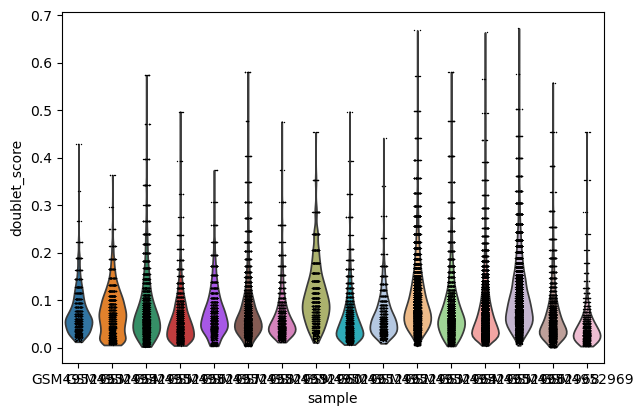

In [18]:
# 4) 시각화
sc.pl.violin(adata_qc, ['doublet_score'], groupby='sample')

원본 데이터를 counts 레이어에 저장.

총 발현량을 정규화 (normalize_total) 하고 로그 변환 (log1p) 수행한다.

In [19]:
adata_qc.layers["counts"] = adata_qc.X.copy()

### Normalization

In [20]:
# total-counts normalization
sc.pp.normalize_total(adata_qc, target_sum = 1e4)

# log 변환
sc.pp.log1p(adata_qc)

In [21]:
sc.pp.highly_variable_genes(adata_qc,
                            min_mean=0.0125,
                            max_mean=3,
                            min_disp=0.5
                            )

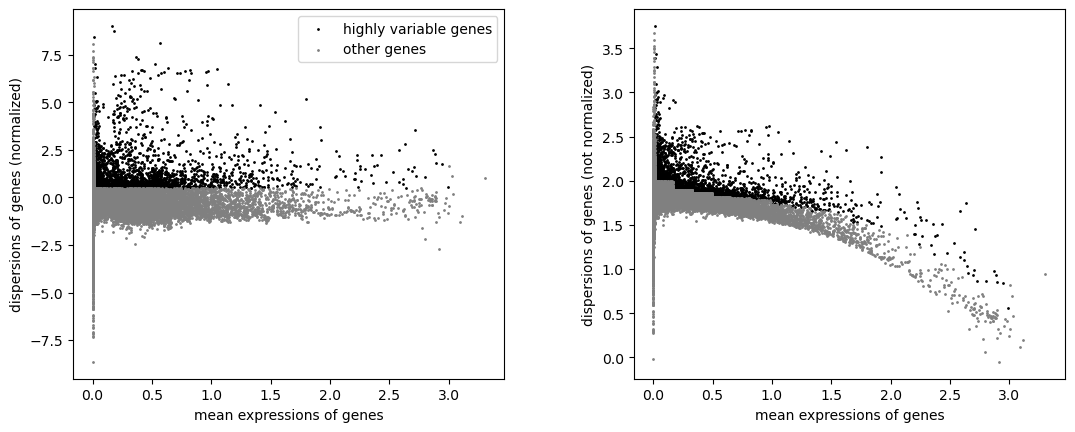

In [22]:
sc.pl.highly_variable_genes(adata_qc)

In [23]:
print(f"HVG 개수 : {adata_qc.var['highly_variable'].sum()}")

HVG 개수 : 2552


HVG 추출 후 PCA 수행

In [24]:
adata_qc = adata_qc[:, adata_qc.var['highly_variable']]

In [25]:
# 유전자별 발현 값이 스케일 차이가 크기 때문에, 평균 0, 분산 1로 맞춰준다.
sc.pp.scale(adata_qc, max_value=10)

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [26]:
sc.tl.pca(adata_qc, svd_solver="arpack")

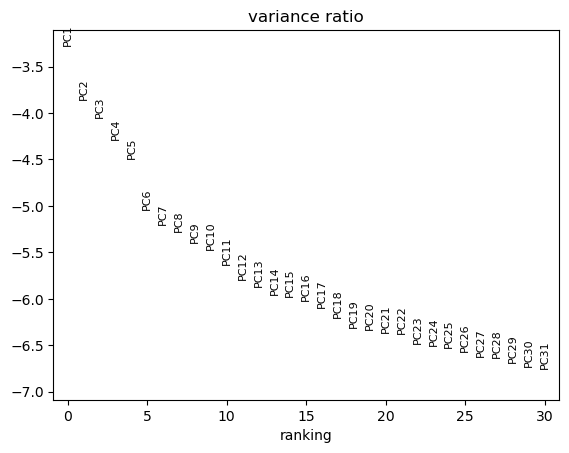

In [27]:
sc.pl.pca_variance_ratio(adata_qc, log=True)

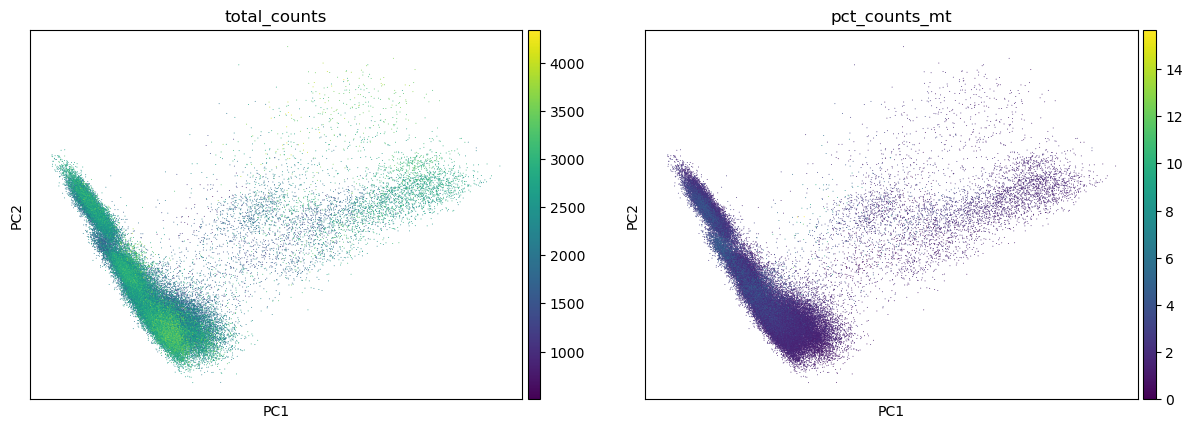

In [28]:
# pca scatter plot
sc.pl.pca(adata_qc, color=['total_counts', 'pct_counts_mt'])

### Nearest neigbor graph construction and visualization

In [29]:
sc.pp.neighbors(adata_qc, n_neighbors=10, n_pcs=40)

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
sc.tl.umap(adata_qc)

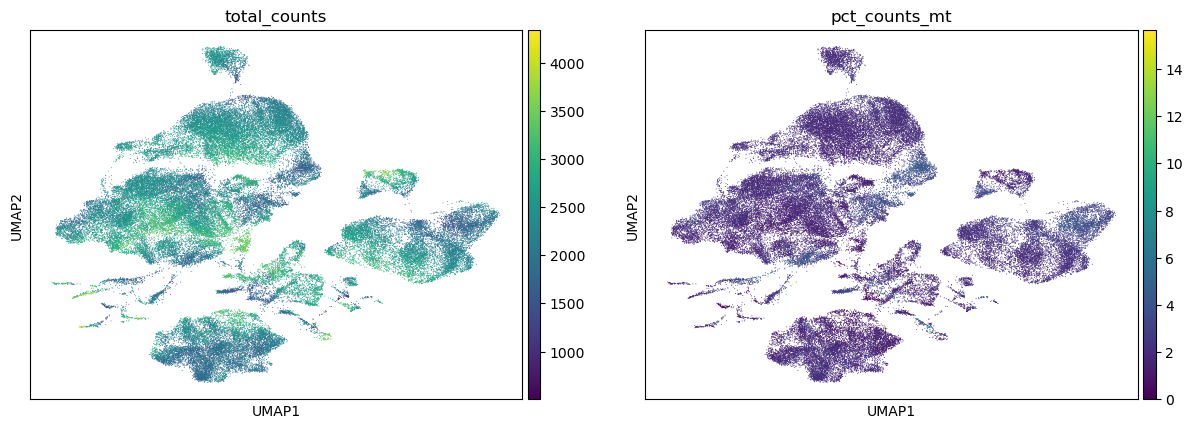

In [31]:
sc.pl.umap(adata_qc, color=['total_counts', 'pct_counts_mt'])

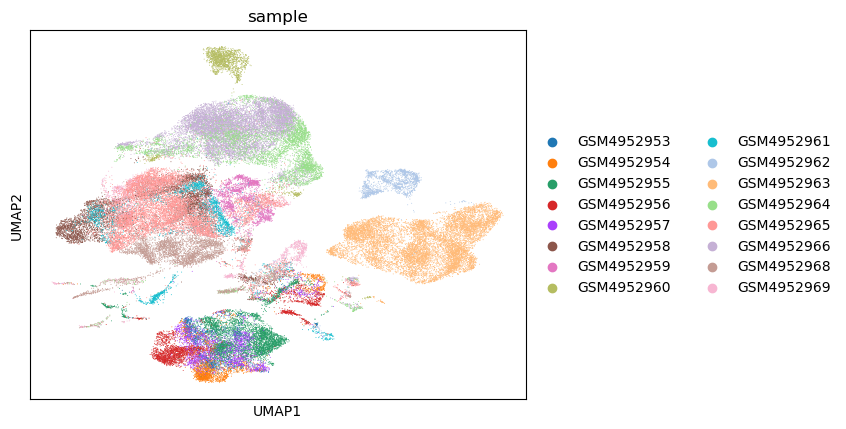

In [32]:
sc.pl.umap(
    adata_qc,
    color=['sample']
)

### Clustering

ledien 알고리즘을 사용하여 클러스터링을 수행하고 결과를 umap에 시각화

In [33]:
# leiden 클러스터링

sc.tl.leiden(adata_qc, resolution=0.5)

/var/folders/m5/z71192pd5msbtxhv764jq3_h0000gn/T/ipykernel_35540/1420486825.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_qc, resolution=0.5)


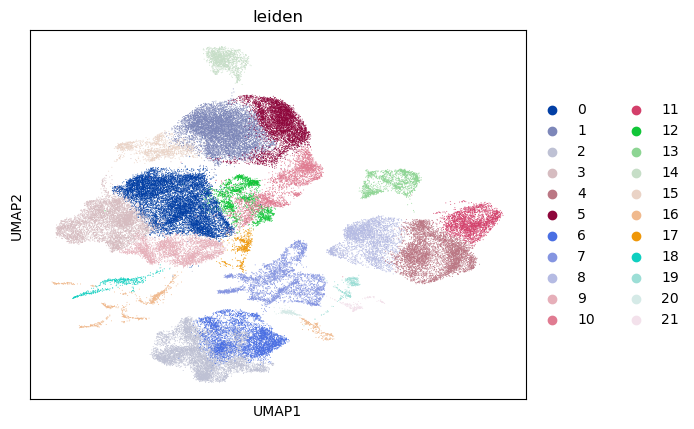

In [34]:
sc.pl.umap(adata_qc, color=['leiden'])

In [35]:
# 클러스터별 차등발현(마커 유전자) 계산
sc.tl.rank_genes_groups(adata_qc, 'leiden', method='wilcoxon')

/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_

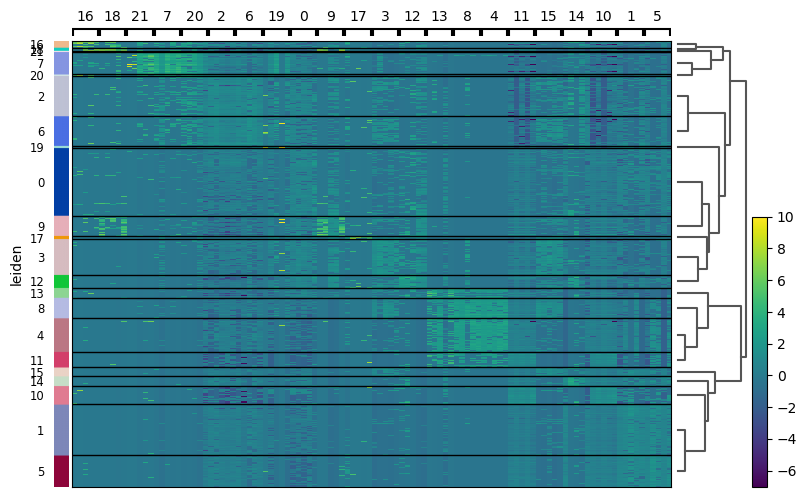

In [36]:

# 상위 마커 유전자 heatmap
sc.pl.rank_genes_groups_heatmap(adata_qc, n_genes=5, groupby='leiden')

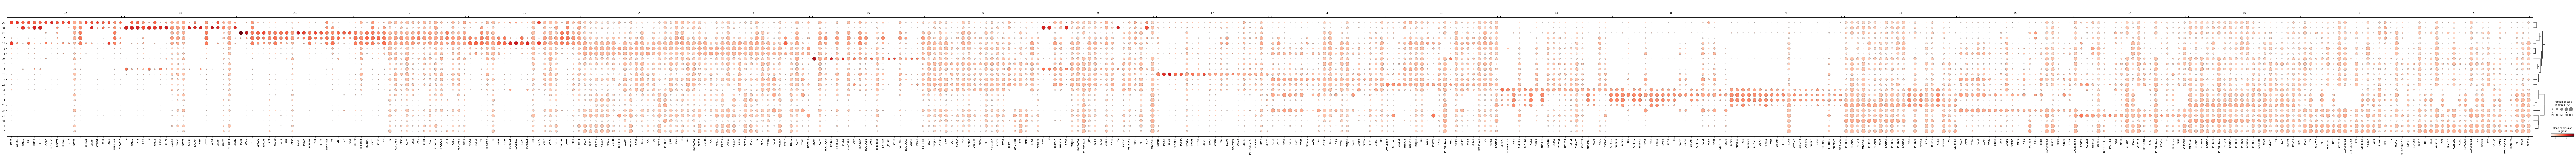

In [37]:
# 클러ㅡ터별 top 20 마커 유전자 목록
sc.pl.rank_genes_groups_dotplot(adata_qc, n_genes=20)

In [38]:
# 클러스터별 top 5 gene 추출
marker_df = sc.get.rank_genes_groups_df(adata_qc, group=None, key='rank_genes_groups', pval_cutoff=0.05)
marker_df.groupby('group').head(5)

/var/folders/m5/z71192pd5msbtxhv764jq3_h0000gn/T/ipykernel_35540/1226819706.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_df.groupby('group').head(5)


group   names     scores  logfoldchanges          pvals      pvals_adj
0         0    SRGN  73.556915             NaN   0.000000e+00   0.000000e+00
1         0  DNAJB1  72.992470             NaN   0.000000e+00   0.000000e+00
2         0   ZFP36  67.039177             NaN   0.000000e+00   0.000000e+00
3         0    JUNB  66.937401             NaN   0.000000e+00   0.000000e+00
4         0    BATF  66.767647             NaN   0.000000e+00   0.000000e+00
...     ...     ...        ...             ...            ...            ...
22887    21    FCN1  21.633314             NaN  8.728222e-104  2.227442e-100
22888    21    VCAN  19.454447             NaN   2.672173e-84   3.409693e-81
22889    21    CST3  18.720657             NaN   3.359740e-78   2.858019e-75
22890    21  S100A9  18.571966             NaN   5.418129e-77   3.456766e-74
22891    21  S100A8  18.386602             NaN   1.681961e-75   8.584730e-73

[110 rows x 6 columns]

In [39]:
for clus in adata_qc.obs['leiden'].unique():
    top = marker_df[marker_df['group'] == clus].head(10)
    print(f"Cluster {clus}")
    print(top[['names','scores']])
    print("----------")

Cluster 2
       names      scores
2546   RPS17  113.718193
2547   RPS10  106.765770
2548  RPL27A  105.374748
2549  RPL13A  103.473152
2550   RPS20  103.151566
2551  TMSB4X   98.923927
2552  NBEAL1   91.204254
2553   CXCR4   82.278107
2554  RPL36A   80.816521
2555    RGS1   80.130981
----------
Cluster 6
       names     scores
7879   RPS17  88.861343
7880  TMSB4X  87.064796
7881    TRAC  86.406181
7882   RPS10  83.513222
7883  RPL27A  80.296944
7884   ATP5E  73.239510
7885  RPL13A  72.828903
7886    RGS1  69.193733
7887   RPS29  65.136597
7888   RPS20  64.877632
----------
Cluster 0
    names     scores
0    SRGN  73.556915
1  DNAJB1  72.992470
2   ZFP36  67.039177
3    JUNB  66.937401
4    BATF  66.767647
5  SLC2A3  66.745216
6     FOS  65.418762
7  NFKBIA  57.127346
8  CSRNP1  56.650040
9    CREM  56.474949
----------
Cluster 7
         names     scores
9289    TYROBP  94.368515
9290   HLA-DRA  92.227028
9291    FCER1G  91.027008
9292      CST3  90.603050
9293      CD68  88.551178
9

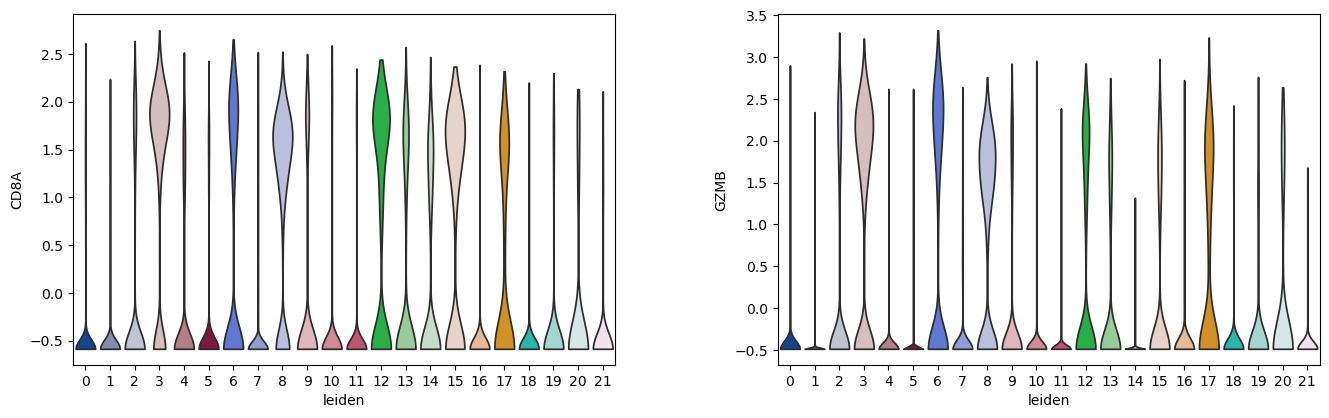

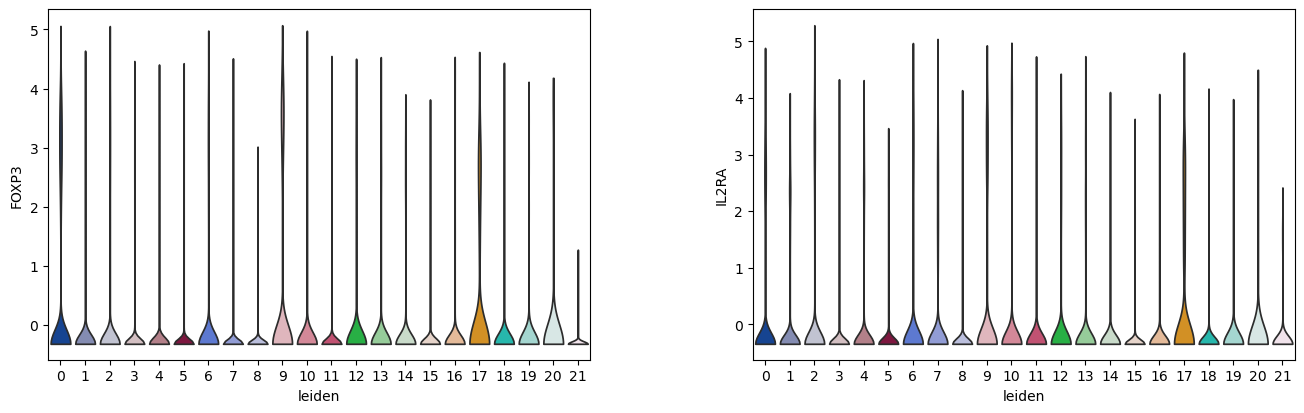

In [40]:
# CD8 + T cell markers
sc.pl.violin(
    adata_qc,
    keys=['CD8A', 'GZMB'],
    groupby='leiden',
    stripplot=False,
    jitter=0.4
)

# Treg markers
sc.pl.violin(
    adata_qc,
    keys=['FOXP3', 'IL2RA'],
    groupby='leiden',
    stripplot=False,
    jitter=0.4
)

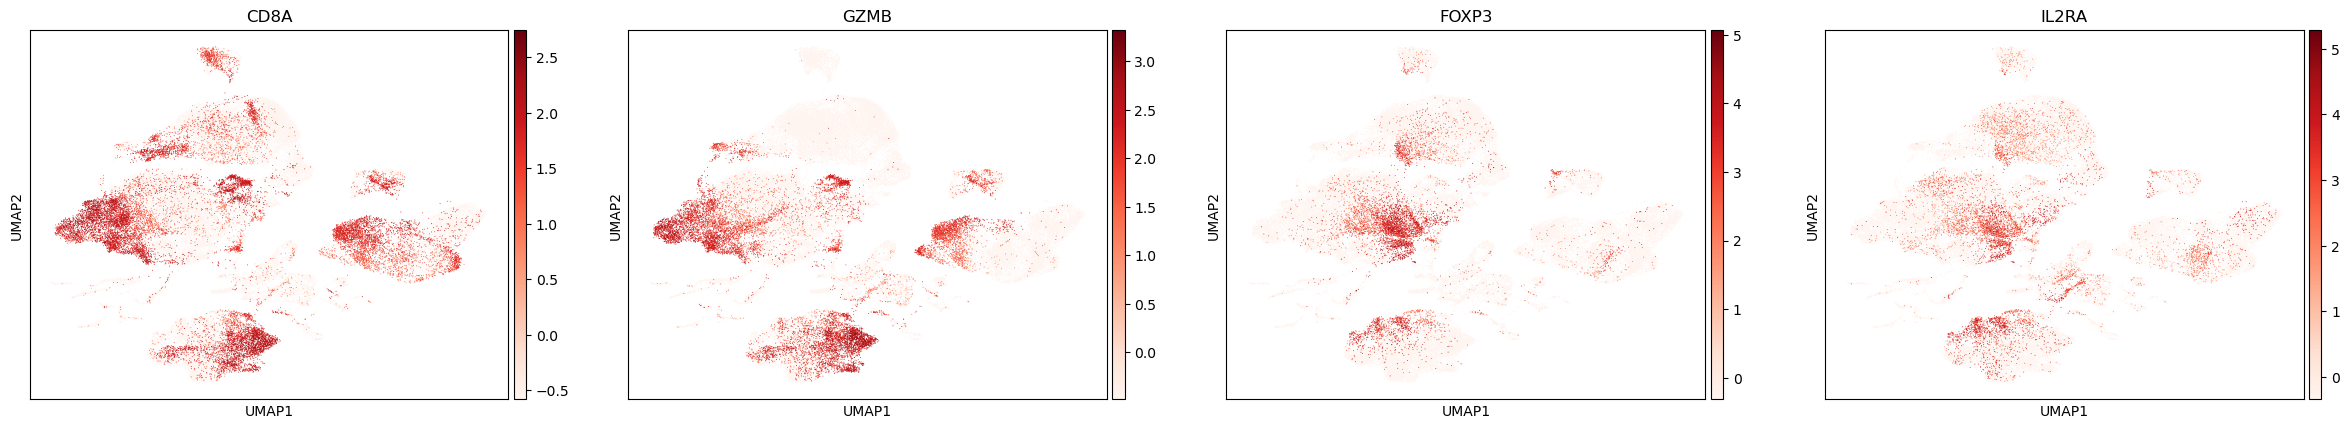

In [41]:
# UMAP 상 발현 시각화
sc.pl.umap(
    adata_qc,
    color=['CD8A', 'GZMB', 'FOXP3', 'IL2RA'],
    cmap='Reds'
)


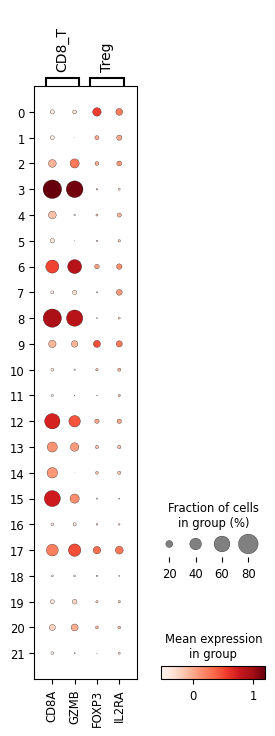

In [42]:
# 클러스터별 평균 발현 (dot plot)
marker_genes_tcells = {
    'CD8_T': ['CD8A', 'GZMB'],
    'Treg': ['FOXP3', 'IL2RA']
}

sc.pl.dotplot(adata_qc, marker_genes_tcells, groupby='leiden')


CD8A, GZMB 같은 경우에는 cluster 3, 6, 8, 12,15, 17 

FOXP3, IL2RA 같은 경우에는 cluster 1, 9 ,17 가장 크게 발현이 잘 된걸 확인을 할 수 있다.

In [43]:
print(adata_qc.var_names[:10])

Index(['ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4', 'CCNL2', 'RP5-892K4.1', 'HES2',
       'TNFRSF9', 'ERRFI1', 'RERE'],
      dtype='object')


In [44]:
print([g for g in adata_qc.var_names if "CD19" in g])

['CD19']


KeyError: 'Could not find key FAP in .var_names or .obs.columns.'

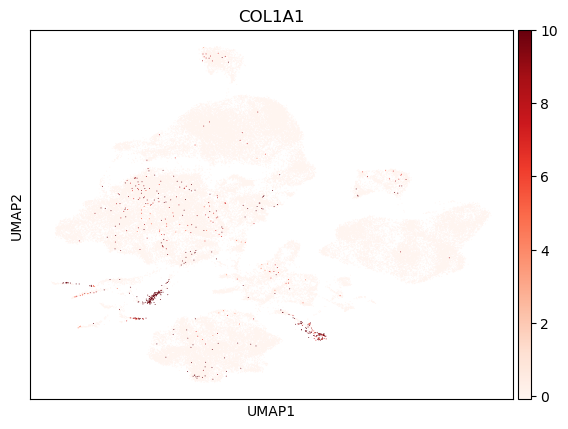

In [45]:
sc.pl.umap(adata_qc, color=['COL1A1','FAP', 'PDGFRB'], cmap='Reds')

In [47]:
caf_markers = ["COL1A1", "COL1A2", "ACTA2", "PDGFRB", "TAGLN", "FN1"]

[g for g in caf_markers if g in adata_qc.var_names]

['COL1A1', 'FN1']

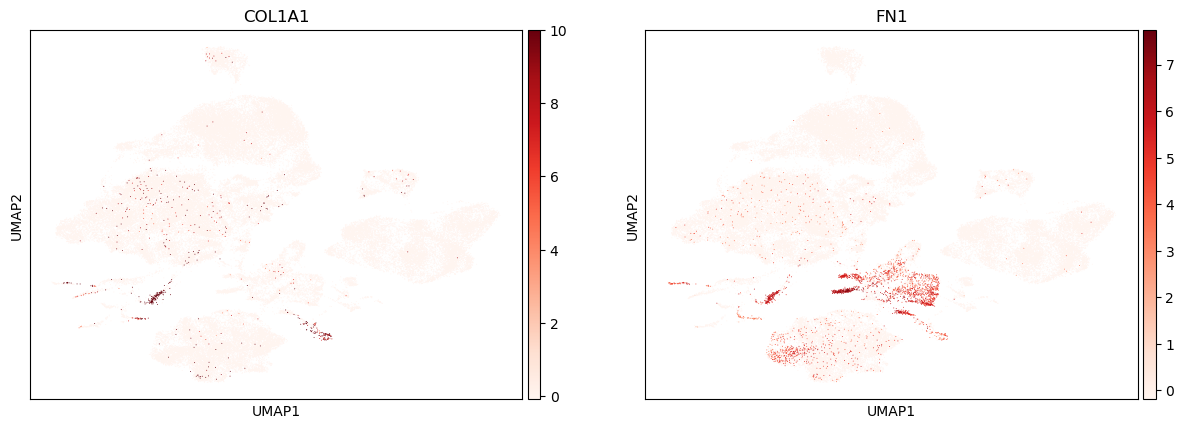

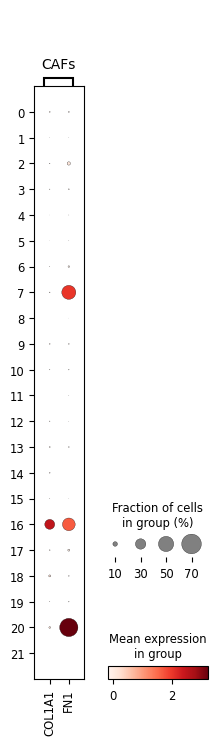

In [52]:
#CAF marker만 골라 시각화
caf_available = [g for g in ["COL1A1","COL1A2","TAGLN","FN1"] if g in adata_qc.var_names]

sc.pl.umap(adata_qc, color=caf_available, cmap="Reds")
sc.pl.dotplot(adata_qc, { "CAFs": caf_available }, groupby="leiden")

In [53]:
bcell_markers = ["CD79A", "MS4A1", "CD19"]
[g for g in bcell_markers if g in adata_qc.var_names]

['CD79A', 'MS4A1', 'CD19']

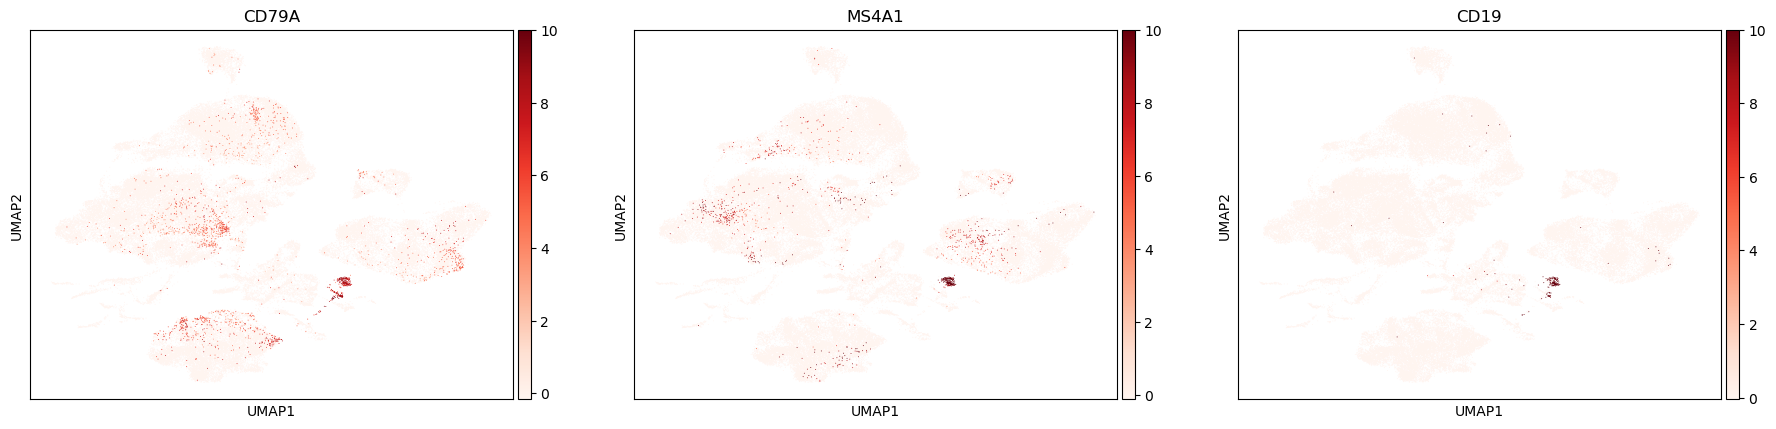

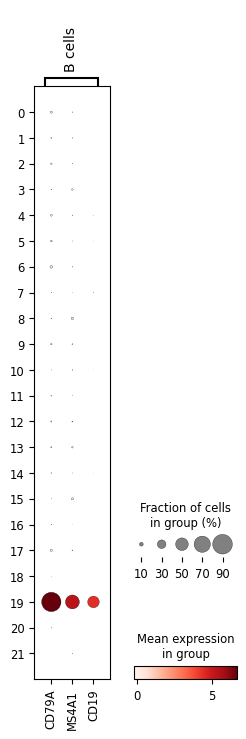

In [54]:
b_available = [g for g in bcell_markers if g in adata_qc.var_names]

sc.pl.umap(adata_qc, color= b_available, cmap='Reds')
sc.pl.dotplot(adata_qc, {'B cells': b_available}, groupby='leiden')

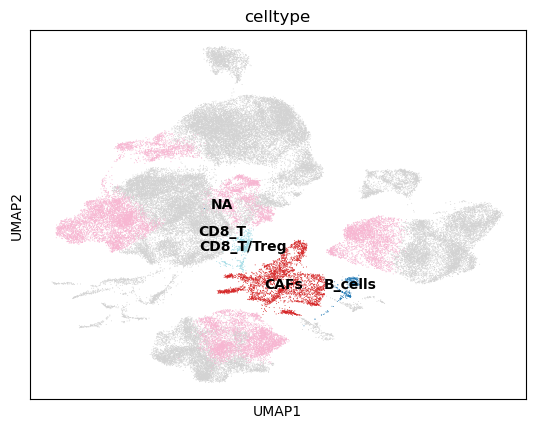

In [61]:
cluster_annotation = {
    "3": "CD8_T",
    "6": "CD8_T",
    "8": "CD8_T",
    "12": "CD8_T",
    "15": "CD8_T",
    "17": "CD8_T/Treg",  # CD8 marker + FOXP3/IL2RA 동시 발현
    "7": "CAFs",
    "20": "CAFs",
    "19": "B_cells"
}

adata_qc.obs["celltype"] = adata_qc.obs['leiden'].map(cluster_annotation)

sc.pl.umap(adata_qc, color=['celltype'], legend_loc='on data')

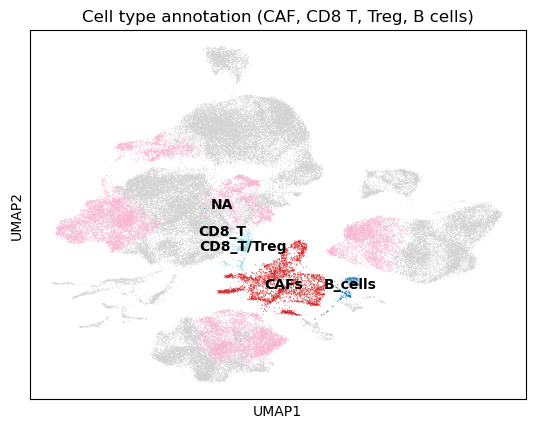

In [62]:
# UMAP에 최종 celltype annotation 표시
sc.pl.umap(
    adata_qc,
    color='celltype',
    legend_loc='on data',
    title='Cell type annotation (CAF, CD8 T, Treg, B cells)',
    palette='tab20'
)


In [65]:
print(adata_qc.obs.columns)

Index(['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'pct_counts_hb', 'sample', 'n_genes', 'doublet_score',
       'predicted_doublet', 'leiden', 'celltype'],
      dtype='object')


### 남아 있는 NA cluster 확인

이 cluster 들이 어떤 marker 유전자를 가지는지 자동 탐색

→ macrophage, NK cell, endothelial cell 같은 다른 면역 세포군 후보 확인

In [66]:
na_cluster = adata_qc.obs.loc[adata_qc.obs['celltype'].isna(), 'leiden'].unique()
print("남아 있는 NA 클러스터:", na_cluster)

남아 있는 NA 클러스터: ['2', '0', '16', '10', '1', ..., '4', '11', '13', '18', '21']
Length: 13
Categories (22, object): ['0', '1', '2', '3', ..., '18', '19', '20', '21']


In [69]:
# 2) 각 NA 클러스터별로 marker 추출
for cluster in na_cluster:
    print(f"\n=== Cluster {cluster} (NA) top 10 marker genes ===")
    
    sc.tl.rank_genes_groups(
        adata_qc,
        groupby="leiden",
        groups=[str(cluster)],   # <-- 반드시 리스트 안에 str로 넣기
        reference="rest",
        method="wilcoxon"
    )



=== Cluster 2 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 0 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 16 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 10 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 1 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 5 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 9 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 14 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 4 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 11 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 13 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 18 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



=== Cluster 21 (NA) top 10 marker genes ===


/Users/yanghyejeong/miniforge3/envs/rna_analysis_env/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [70]:
# 상위 10개 마커 출력
top_genes = sc.get.rank_genes_groups_df(
    adata_qc, group=str(cluster), key= 'rank_genes_groups', pval_cutoff=0.05
).head(10)

print(top_genes[['names', 'scores', 'pvals_adj']])

    names     scores      pvals_adj
0    FCN1  21.633314  2.227442e-100
1    VCAN  19.454447   3.409693e-81
2    CST3  18.720657   2.858019e-75
3  S100A9  18.571966   3.456766e-74
4  S100A8  18.386602   8.584730e-73
5    AIF1  18.357393   1.225408e-72
6  TYROBP  18.295605   3.270190e-72
7    LST1  18.238932   8.082142e-72
8    SPI1  18.068695   1.594383e-70
9    CTSS  17.900415   2.987039e-69
